Code für die Vorlesung

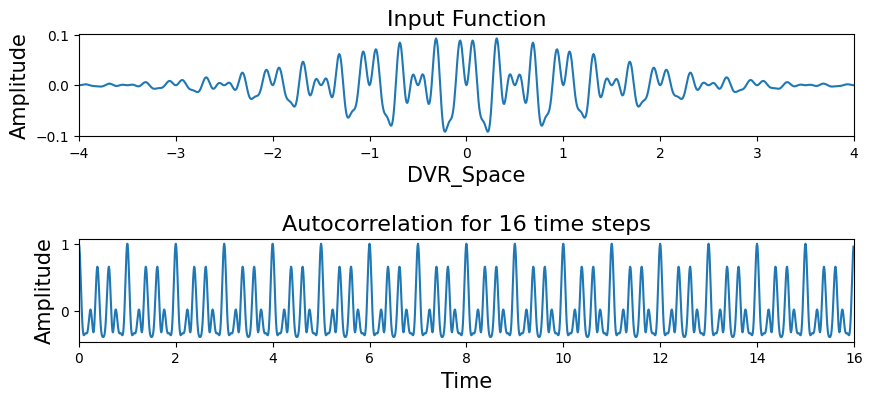

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import Modul_WP as MF
import Modul_ACC as MF_ACC
import math
from scipy.sparse import diags
from numpy.fft import fft, fftfreq, ifft
from IPython.display import HTML

################## Define grid parameters and time steps ################
NOP  = 1024                                                              # Number of points on our x-Axis
DVR  = 4                                                                # Min/Max of our x-Axis
time_end  = 16                                                          # Propagation time of our Wave
samp_rate = 100                                                          # Define how many functions are generated for each time point 
Mirror    = False                                                       # Propagate wave by reflecting between wals, not recommended
Plot_Psi0 = True                                                        # Plot the initial wave
Plot_ACC  = True                                                        # Plot the autocorrelation of the initial wave
Video     = False                                                       #
#########################################################################


######################### Define inputfunction ##########################

def Define_Wave(x,t):
    mode  = 'Wave_pack'
    x0    = 0
    sigma = 1
    LK    = sin_wave(1,3,x,t) + sin_wave(2,5,x,t)
    SD1   = sin_wave(1,3,x,t) * sin_wave(2,5,x,t)
    SD2   = sin_wave(1,1,x,t) * sin_wave(3,4,x,t)
    func1 = SD1
    func2 = SD2
    if mode == 'Plane_Wave':
        Psi = (func1 + func2)
    if mode == 'Wave_pack':
        Psi = (func1+func2)*np.exp(-1/4*(x-x0)**2/sigma**2)
    if mode == 'gauß_wave':
        Psi = gauß_wave(x,t,sigma)  
    return Psi

def sin_wave(a,f,x,t):
    p = 0
    x  = a * np.sin(2*np.pi*f*(x-t)+(np.pi/180*p))
    return x

############### Needed Modules, dont change anything past here ############

def Mirror_Wave(x,DVR,NOP,Mirror,t):
    while t > 4*DVR:
        t -= 4 * DVR
        
    result_func = np.zeros(len(x))
    
    if Mirror == True:
        func = Define_Wave(x,0)
        if t <= 2*DVR:
            space = int((2*DVR-t)/(2*DVR/NOP))+1
            result_func[:space] += np.flip(func[:space])
            add = func[space:]
            for k,item in enumerate(add,start=1):
                result_func[k] += item        
            result_func = np.flip(result_func)
        else:
            t -= 2*DVR
            space = int((2*DVR-t)/(2*DVR/NOP))+1
            result_func[:space] += np.flip(func[:space])
            add = func[space:]
            for k,item in enumerate(add,start=1):
                result_func[k] += item        
    else:
        result_func = Define_Wave(x,t)
    return result_func


x_array = np.arange(-DVR,DVR+2*DVR/NOP,2*DVR/NOP)
Psi0    = Mirror_Wave(x_array,DVR,NOP,Mirror,0)
norm    = MF_ACC.Overlap(Psi0,Psi0)
Psi0    = Psi0/np.sqrt(norm)

x_step   = np.arange(0,time_end,1/samp_rate)
t_frames = np.arange(0,time_end*samp_rate+1,1)

ACC = np.zeros(len(x_step))
for key,i in enumerate(x_step):
    Psi = Mirror_Wave(x_array,DVR,NOP,Mirror,i)/np.sqrt(norm)
    ACC[key] = MF_ACC.Overlap(Psi0,Psi)
#####################################################################################################################

NOPl = np.sum([Plot_Psi0, Plot_ACC])
P    = 1
fig  = plt.figure(dpi=100,figsize=(10,NOPl*2))

if Plot_Psi0 == True:

    ax1 = plt.subplot(NOPl,1,P)
    plt.plot=ax1.plot(x_array, Psi0)
    plt.xlim(xmin=-DVR,xmax=+DVR) 
    plt.title(f'Input Function', fontsize = 16)
    plt.ylabel('Amplitude', fontsize = 15)
    plt.xlabel('DVR_Space', fontsize = 15)
    P+=1
    
if Plot_ACC == True:
    
    ax1 = plt.subplot(NOPl,1,P)
    plt.plot=ax1.plot(x_step, ACC)
    plt.xlim(xmin=0,xmax=time_end) 
    plt.title(f'Autocorrelation for {time_end} time steps', fontsize = 16)
    plt.ylabel('Amplitude', fontsize = 15)
    plt.xlabel('Time', fontsize = 15)
    P+=1
    
plt.subplots_adjust(hspace=1)

if Video == True:
    
    fig2, (ax1, ax2) = plt.subplots(2,1,dpi=100,figsize=(10,4))
    plt.plot = ax1.plot(x_array, Psi0)
    line1,   = ax1.plot(x_array, Psi0, lw=2)
    line2,   = ax2.plot([], [], lw=2)
    line     = [line1, line2]

    ax1.set_ylim(-0.2, 0.2)
    ax1.set_xlim(-DVR, DVR)

    ax2.set_ylim(-1.2, 1.2)
    ax2.set_xlim(0, time_end)
    x2,y2 =[],[]
    
    def update(frame):
        t = t_frames[frame]*1/samp_rate
        y1 = MF_ACC.Mirror_Wave(x_array,DVR,NOP,Mirror,x_step[frame])
        y1 = y1/np.sqrt(norm)
        x2.append(t)
        y2.append(MF_ACC.Overlap(Psi0,y1))
        line[0].set_ydata(y1)
        line[1].set_xdata(x2)
        line[1].set_ydata(y2)
        return line

    ani = FuncAnimation(fig2, update, frames=t_frames, interval=100, blit=True)
    plt.close()
    HTML(ani.to_jshtml())

Evaluation of the Autocorrelation via Fourier Transformation

DFT Peaks (Frequency, Amplitude, Phase)
[[ 2.00000000e+00  1.53842712e-01 -2.06740680e-15]
 [ 3.00000000e+00  3.46152943e-01  1.89393690e-14]
 [ 5.00000000e+00  3.46157750e-01  1.90195025e-14]
 [ 8.00000000e+00  1.53846595e-01 -2.19139589e-14]
 [ 9.20000000e+01  1.53846595e-01  1.41223061e-11]
 [ 9.50000000e+01  3.46157750e-01 -4.66382091e-12]
 [ 9.70000000e+01  3.46152943e-01  1.44691152e-11]
 [ 9.80000000e+01  1.53842712e-01  2.59901978e-11]]

FFT Peaks (Frequency, Amplitude, Phase)
[[ 8.00000000e+00  1.53846595e-01  4.30568868e-13]
 [ 5.00000000e+00  3.46157750e-01  2.61296414e-13]
 [ 3.00000000e+00  3.46152943e-01  1.54208014e-13]
 [ 2.00000000e+00  1.53842712e-01  9.71010137e-14]
 [ 2.00000000e+00  1.53842712e-01 -9.84085635e-14]
 [ 3.00000000e+00  3.46152943e-01 -1.52271551e-13]
 [ 5.00000000e+00  3.46157750e-01 -2.61481558e-13]
 [ 8.00000000e+00  1.53846595e-01 -4.28949915e-13]]

Absolut error between ACC and reconstructed function 0.0


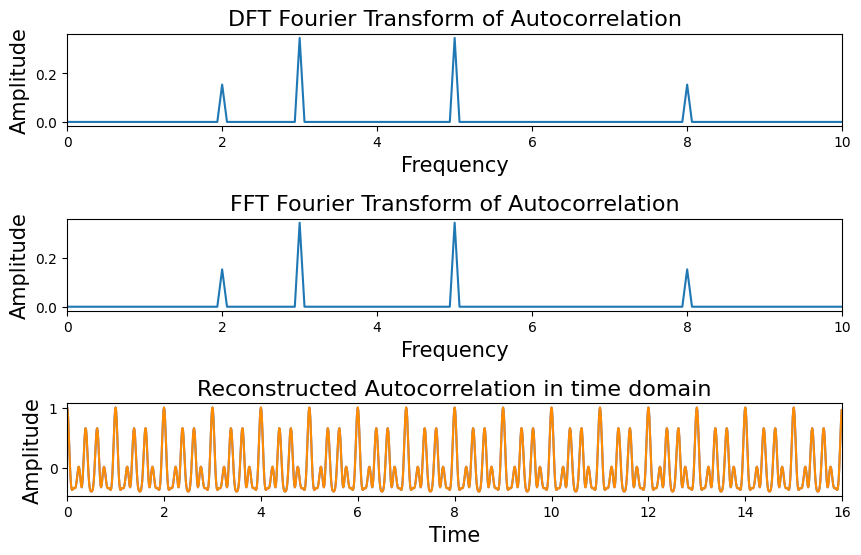

In [3]:
############### Define parameters for autocorrelation ###################
Plot_FT_FFT     = True                                                  # Calculate autocorrelation using FFT
Plot_FT_DFT     = True                                                  # Calculate autocorrelation using DFT
Reconstruct_Inp = True                                                  # Reconstruct the input function using the FT result
######### Scan routine to define highest periodicity ####################
PS_scan   = False                                                       # Scan different end points, find highest periodicity of the input
PS_start  = 10                                                          # Time point for starting the scan
PS_stop   = time_end                                                    # Final Time point (should be time_end in most cases)
PS_step   = 1                                                           # Time stepsize between time start and stop
#########################################################################

############### Routines for calculating and plotting FFT ###############
NOP = np.sum([Plot_FT_FFT, Plot_FT_DFT, Reconstruct_Inp,PS_scan])
P=1
fig3 = plt.figure(dpi=100,figsize=(10,NOP*2))

x_min = 0
x_max = samp_rate/2
x_max = 10
Peak_thresh=0.1

if Plot_FT_DFT == True:
    x_array_FD = MF.freq_FD(x_step,samp_rate)
    y_array_FD = MF.DFT_new(ACC,0,time_end,samp_rate)
    y_array_FD = y_array_FD/len(x_step)*2
    MOP = MF.Peak_detection(x_array_FD,y_array_FD,Peak_thresh)
    print('DFT Peaks (Frequency, Amplitude, Phase)')
    print(MOP)
    print()

    ax1 = plt.subplot(NOP,1,P)
    plt.plot=ax1.plot(x_array_FD, np.abs(y_array_FD))
    plt.xlim(xmin=x_min,xmax=x_max)
    plt.title(f'DFT Fourier Transform of Autocorrelation', fontsize = 16)
    plt.ylabel('Amplitude', fontsize = 15)
    plt.xlabel('Frequency', fontsize = 15)
    P+=1

if Plot_FT_FFT == True:
    
    y_array_FD = np.fft.fftshift(np.fft.fft(ACC))
    x_array_FD = np.fft.fftshift(np.fft.fftfreq(len(ACC), 1/samp_rate))
    y_array_FD = y_array_FD/(len(x_array_FD))*2
    MOP = MF.Peak_detection(x_array_FD,y_array_FD,Peak_thresh)
    print('FFT Peaks (Frequency, Amplitude, Phase)')
    print(MOP)
    print()
         
    ax1 = plt.subplot(NOP,1,P)
    plt.plot=ax1.plot(x_array_FD, np.abs(y_array_FD))
    plt.xlim(xmin=x_min,xmax=x_max)
    plt.title(f'FFT Fourier Transform of Autocorrelation', fontsize = 16)
    plt.ylabel('Amplitude', fontsize = 15)
    plt.xlabel('Frequency', fontsize = 15)
    P+=1

if PS_scan == True:
    
    scan = np.arange(PS_start,PS_stop+PS_step,PS_step)
    print('Percentage error for the reconstructed function for differend end points')
    print()
    Error_type = {'abs_err':0}
    Error_min  = np.full(len(Error_type), np.inf)
    step_min   = np.zeros(len(Error_type))
        
    for key,sc_step in enumerate(scan):
        PS_x_array_TD = x_step[:-int((time_end-sc_step)*samp_rate) or None] 
        PS_y_array_TD = ACC[:-int((time_end-sc_step)*samp_rate) or None]
        
        PS_y_array_FD = np.fft.fftshift(np.fft.fft(PS_y_array_TD))
        PS_x_array_FD = np.fft.fftshift(np.fft.fftfreq(len(PS_y_array_FD), 1/samp_rate))
        PS_y_array_FD = PS_y_array_FD/(len(PS_x_array_FD))*2
        
        PS_MOP = MF.Peak_detection(PS_x_array_FD,PS_y_array_FD,Peak_thresh)
        
        PS_rec_real = np.zeros(len(PS_x_array_TD),dtype=np.complex128)
        PS_rec_imag = np.zeros(len(PS_x_array_TD),dtype=np.complex128)
        
        for row in PS_MOP:
            freq, amp, phase = row[0], row[1], row[2]
            PS_rec_real += amp/2 * np.cos(2*np.pi*freq*PS_x_array_TD+(np.pi/180*phase))
            PS_rec_imag += amp/2 * np.sin(2*np.pi*freq*PS_x_array_TD+(np.pi/180*phase))

        PS_y_array_rec = np.vectorize(complex)(PS_rec_real, PS_rec_imag)
        
        Error_type['abs_err']  =sum(abs(PS_y_array_TD-PS_y_array_rec.real)/len(x_step))
        print('End point', "%0.3f" % sc_step, 'Abs. Err',"%0.3f" % round(Error_type['abs_err'],3))
        
        for Index, (Arg,Error) in enumerate(Error_type.items(),start=0):
            if Error < Error_min[Index]:
                Error_min[Index]  = Error
                step_min[Index]   = sc_step
                if Arg == 'abs_err':
                    Ret_func_y = PS_y_array_FD
                    Ret_func_x = PS_x_array_FD

    print()          
    for Index, (Arg,Error) in enumerate(Error_type.items(),start=0): 
        print(f'Minimal {Arg} error at step {step_min[Index]} with {Error_min[Index]}')
    print()
    
    MOP = MF.Peak_detection(Ret_func_x,Ret_func_y,Peak_thresh)
    
    print(f'List of Peaks for the smallest absolut error')
    print('DFT Peaks (Frequency, Amplitude, Phase)')
    print(MOP)
    print()

if Reconstruct_Inp == True:
    rec_real = np.zeros(len(x_step),dtype=np.complex128)
    rec_imag = np.zeros(len(x_step),dtype=np.complex128)
        
    for row in MOP:
        freq, amp, phase = row[0], row[1], row[2]
        rec_real += amp/2 * np.cos(2*np.pi*freq*x_step+(np.pi/180*phase))
        rec_imag += amp/2 * np.sin(2*np.pi*freq*x_step+(np.pi/180*phase))

    y_array_rec = np.vectorize(complex)(rec_real, rec_imag)
    
    ax1 = plt.subplot(NOP,1,P)
    
    plt.plot=ax1.plot(x_step, ACC, color='royalblue')
    plt.plot=ax1.plot(x_step, y_array_rec.real, color='darkorange') 

    abs_err =sum(abs(ACC-y_array_rec.real))/len(x_step)
    print('Absolut error between ACC and reconstructed function', round(abs_err,3))

    plt.xlim(xmin=0,xmax=time_end)
    plt.title(f'Reconstructed Autocorrelation in time domain', fontsize = 16)
    plt.ylabel('Amplitude', fontsize = 15)
    plt.xlabel('Time', fontsize = 15)
    P+=1
plt.subplots_adjust(hspace=1)